In [232]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [233]:
z = 0.7

label_color_mapping = {
    1 : (z,1,z), 
    2 : (z,z,z),						
    3 : (1,1,z), 
    4 : (1,z,1), 
    5 : (z,1,1), 
    6 : (1,z,0), 
    7 : (z,0,1), 
    8 : (0,1,z), 
    9 : (1,0,0), 
    10 : (0,1,0), 
    11 : (0,0,1), 
    12 : (1,1,0), 
    13 : (1,0,1), 
    14 : (0,1,1), 
    15 : (1,z,z), 
    16 : (1,1,1)
}

f2rgb = [[int(z * 255) for z in color] for label, color in label_color_mapping.items()]		

label_rgb_mapping = {l+1 : rgb for l, rgb in enumerate(f2rgb)}
print(label_rgb_mapping)

{1: [178, 255, 178], 2: [178, 178, 178], 3: [255, 255, 178], 4: [255, 178, 255], 5: [178, 255, 255], 6: [255, 178, 0], 7: [178, 0, 255], 8: [0, 255, 178], 9: [255, 0, 0], 10: [0, 255, 0], 11: [0, 0, 255], 12: [255, 255, 0], 13: [255, 0, 255], 14: [0, 255, 255], 15: [255, 178, 178], 16: [255, 255, 255]}


In [234]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])

test_data_dir = flightmare_path / "flightpy/results/tests/env_test"
semseg = Image.open(test_data_dir / "seg/540.png")
semseg = np.array(semseg)

h, w, c = semseg.shape

# print(semseg[:2, :2, :])
# plt.imshow(semseg[:2, :2, :])

### Compute the pixel distances and take the label for the minimum distance

* test the image color problem (due to the data type of the reconstruct image, it should be int.)

In [235]:
# repeat_semseg = np.repeat(semseg[:, :, :, np.newaxis], len(f2rgb), axis=3)
# check_pixels = repeat_semseg[:2, :2, :, :]
# plaette = np.array(f2rgb).transpose()

# print(check_pixels)
# print(plaette)

# dists = check_pixels - plaette
# dists_sum = np.sum(np.abs(dists), axis=2)
# semseg_label = np.argmin(dists_sum, axis=2) + 1
# print(semseg_label)

# reconstruct_semseg_1 = np.zeros(shape=(2*2, 3))
# for label, rgb in label_rgb_mapping.items():
#     reconstruct_semseg_1[semseg_label.reshape(-1).squeeze() == label] = rgb

# reconstruct_semseg_1 = reconstruct_semseg_1.reshape(2, 2, 3).astype(int)
# loss_1 = np.mean(np.abs(reconstruct_semseg_1 - semseg[:2, :2, :]))

# print(reconstruct_semseg_1)
# plt.imshow(reconstruct_semseg_1)

In [236]:
# this method takes 0.12s on average per image
dists =  np.repeat(semseg[:, :, :, np.newaxis], len(f2rgb), axis=3)- np.array(f2rgb).transpose()
dists_sum = np.sum(np.abs(dists), axis=2)
semseg_label = np.argmin(dists_sum, axis=2) + 1

print(dists_sum.shape)
print(semseg_label.shape)
print(np.unique(semseg_label))

# print(dists_sum)

(480, 640, 16)
(480, 640)
[ 1  2  3  5  6  7  8  9 10 11 14]


In [237]:
# convert back and compute the avg loss
reconstruct_semseg_1 = np.zeros(shape=(h*w, 3))
for label, rgb in label_rgb_mapping.items():
    reconstruct_semseg_1[semseg_label.reshape(-1).squeeze() == label] = rgb

reconstruct_semseg_1 = reconstruct_semseg_1.reshape(h, w, 3).astype(int)
loss_1 = np.mean(np.abs(reconstruct_semseg_1 - semseg))

### Find the nearest neighbor pixel using KDTree

In [238]:
b = 1
semseg_in_batch = np.stack([np.array(semseg).reshape(-1, 3)] * b).reshape(-1, b, 3)
semseg_in_label = np.zeros(shape=(b, h, w)).transpose(1, 2, 0).reshape(-1, b)

print(semseg.shape)
print(semseg_in_label.shape)

# ---------------------------------------------- this part
for label, rgb in label_rgb_mapping.items():
    # print((semseg == rgb).all(axis=2).shape)
    semseg_in_label[(semseg_in_batch == rgb).all(axis=2)] = label
# takes 0.15s on average ----------------------------------

# ---------------------------------------------- this part
semseg_in_label = semseg_in_label.reshape(h, w, b)

from scipy.interpolate import NearestNDInterpolator
semseg_in_label[semseg_in_label == 0] = np.nan

mask = np.where(~np.isnan(semseg_in_label))
interp = NearestNDInterpolator(np.transpose(mask), semseg_in_label[mask])
semseg_in_label = interp(*np.indices(semseg_in_label.shape))
# takes 0.35s on average ----------------------------------

print(semseg_in_label.shape)
np.unique(semseg_in_label)

(480, 640, 3)
(307200, 1)
(480, 640, 1)


array([ 1.,  2.,  3.,  6.,  8.,  9., 10., 11., 14.])

In [239]:
reconstruct_semseg_2 = np.zeros(shape=(h*w, 3))
for label, rgb in label_rgb_mapping.items():
    reconstruct_semseg_2[semseg_in_label.reshape(-1, 1).squeeze() == label] = rgb

reconstruct_semseg_2 = reconstruct_semseg_2.reshape(h, w, 3).astype(int)
loss_2 = np.mean(np.abs(reconstruct_semseg_2 - semseg))

### Comparison

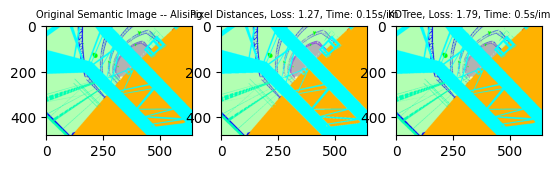

In [240]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(semseg)
axs[0].set_title("Original Semantic Image -- Alising", fontdict={"fontsize": 7})
axs[1].imshow(reconstruct_semseg_1)
axs[1].set_title(f"Pixel Distances, Loss: {loss_1:.02f}, Time: 0.15s/im", fontdict={"fontsize": 7})
axs[2].imshow(reconstruct_semseg_2)
axs[2].set_title(f"KDTree, Loss: {loss_2:.02f}, Time: 0.5s/im", fontdict={"fontsize": 7})

plt.show()